# Exercise. ASI

# Summary

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.special import logsumexp
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from sklearn import metrics
from skimage.color import rgb2gray
import copy
import tensorflow as tf
from tensorflow.contrib.layers  import flatten
import time
from sklearn.metrics import mean_squared_error

# 1. Load data

 Download the Fashion MNIST and CIFAR10 datasets and import them. 

In [2]:
cifarBase = "cifar-10-batches-py"
cifarTrainName = "data_batch_"
cifarSize = 1024
fashion_label_desc = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
cifar_label_desc = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

    
def readCifarData():
    cifarTest = unpickle(cifarBase + "/" + "test_batch")
    cifarTrain = [unpickle(cifarBase + "/" + cifarTrainName + str(i)) for i in range(1,6)]
    cifarTestLabels = cifarTest[b'labels']
    cifarTestData = cifarTest[b'data']
    cifarTrainLabels = np.concatenate([batch[b'labels'] for batch in cifarTrain])
                                      
    cifarTrainData = np.concatenate([batch[b'data'] for batch in cifarTrain])
    cifarTrainData = np.dstack((cifarTrainData[:, :1024], cifarTrainData[:, 1024:2048], cifarTrainData[:, 2048:]))
    
    cifarTrainData = cifarTrainData.reshape(-1,1024, 3)
    
    cifarTestData = np.dstack((cifarTestData[:, :1024], cifarTestData[:, 1024:2048], cifarTestData[:, 2048:]))
    cifarTestData = cifarTestData.reshape(-1,1024, 3)

    return cifarTrainLabels,cifarTrainData,cifarTestLabels,cifarTestData

In [3]:
fashionTest = pd.read_csv("fashion-mnist_test.csv")
fashionTrain = pd.read_csv("fashion-mnist_train.csv")
cifarTrainLabels,cifarTrainData,cifarTestLabels,cifarTestData = readCifarData()
#rgbCifarTrainData = cifarTrainData.reshape(-1,1024 * 3)
#rgbCifarTestData = cifarTestData.reshape(-1,1024 * 3)
grayCifarTrainData = rgb2gray(cifarTrainData)
grayCifarTestData = rgb2gray(cifarTestData)

In [7]:
y_fashion = fashionTrain.label.values
X_fashion = fashionTrain.drop("label",axis=1).values / 255
y_fashion_test = fashionTest.label.values
X_fashion_test = fashionTest.drop("label",axis=1).values / 255

y_cifar = cifarTrainLabels
X_cifar = grayCifarTrainData
#X_cifar_rgb = rgbCifarTrainData
y_cifar_test = cifarTestLabels
X_cifar_test = grayCifarTestData
#X_cifar_test_rgb = rgbCifarTestData

# 2. Comment data

Comment on the distribution of class labels and the dimensionality of the input and how these may
affect the analysis.

In [4]:
print("Fashion MNIST train shape:",fashionTrain.shape)
print("Fashion MNIST test shape:",fashionTest.shape)
print()
print("CIFAR10 train shape:",cifarTrainData.shape)
print("CIFAR10 test shape:",cifarTestData.shape)
print()
print("Grayscale CIFAR10 train shape:",grayCifarTrainData.shape)
print("Grayscale CIFAR10 test shape:",grayCifarTestData.shape)

Fashion MNIST train shape: (60000, 785)
Fashion MNIST test shape: (10000, 785)

CIFAR10 train shape: (50000, 1024, 3)
CIFAR10 test shape: (10000, 1024, 3)

Grayscale CIFAR10 train shape: (50000, 1024)
Grayscale CIFAR10 test shape: (10000, 1024)


From the shapes above we see that the CIFAR10 entries have much more features than the Fashion MNIST entries. This is because CIFAR10 images are colored while Fashion MNIST images are greyscale. Eventualy this may mean that we will run into some space issues as the CIFAR10 dataset will take atleast 150MB of RAM space (most likely much more). The greyscaled version of the CIFAR10 dataset will only take one third of the original datasets space, which is much better for our algorithms. There may be a imformation tradeof by using greyscaled images instead, as by transforming them we lose some of the original image's information. One other thing that we notice is that MNIST images are 28x28 while CIFAR10 images are 32x32.

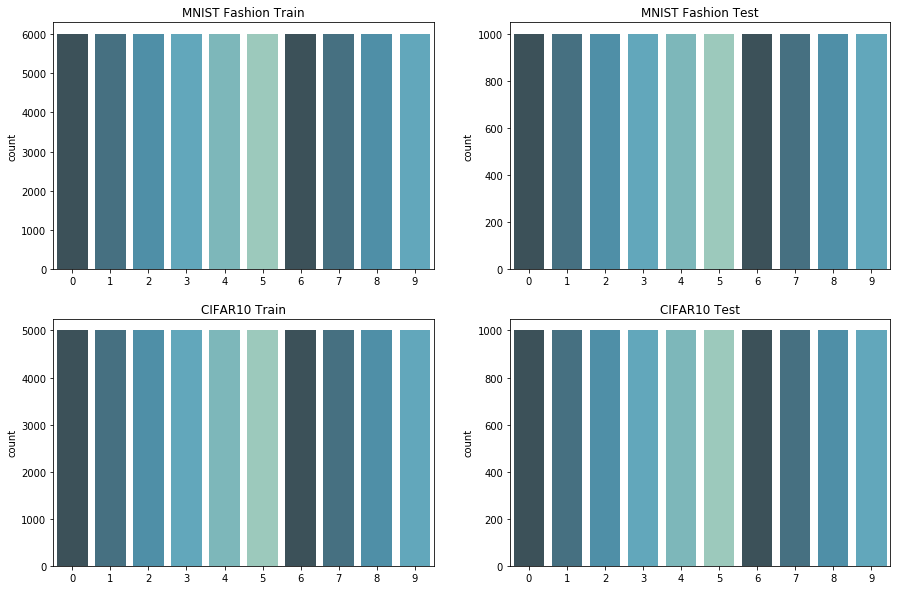

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title("MNIST Fashion Train")
sns.countplot(y_fashion,palette=sns.color_palette("GnBu_d"))
plt.subplot(222)
plt.title("MNIST Fashion Test")
sns.countplot(y_fashion_test,palette=sns.color_palette("GnBu_d"))
plt.subplot(223)
plt.title("CIFAR10 Train")
sns.countplot(y_cifar,palette=sns.color_palette("GnBu_d"))
plt.subplot(224)
plt.title("CIFAR10 Test")
sns.countplot(y_cifar_test,palette=sns.color_palette("GnBu_d"))
plt.show()

From the countplots above we can see that all labels are represented equaly in both the dataset. This means that our predictions will not be biased by some labels more than others, which is good.

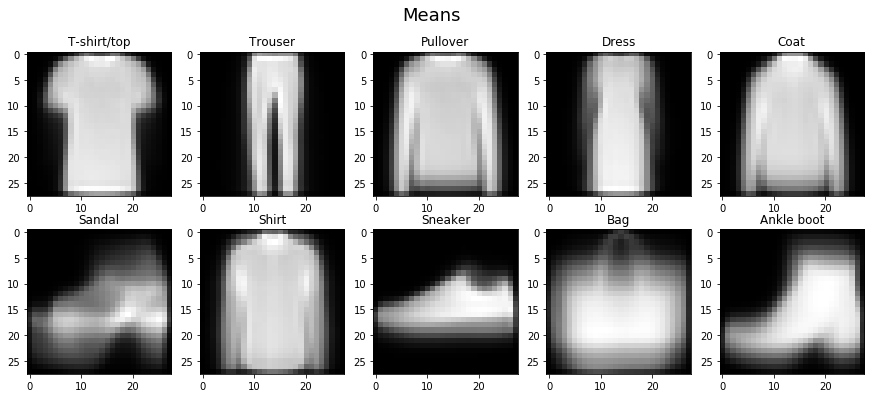

In [9]:
mnistDF = pd.DataFrame(data=X_fashion)
mnistDF["label"] = y_fashion
mnist_means = mnistDF.groupby("label").mean().values.reshape(10,28,28)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Means', fontsize=18)
for ax, label, image in zip(axes.flat, fashion_label_desc, mnist_means):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

The plots above shows the mean of all the labels in the Fashion MNIST dataset. We can see that some of the classes are quite similar, especially Pullover,Coat and Shirt. These three may be hard for our algorithm to distinguish between. We will later see if our algorithms fails to distinguish these three when we plot the confusion matrix for our predictions. 

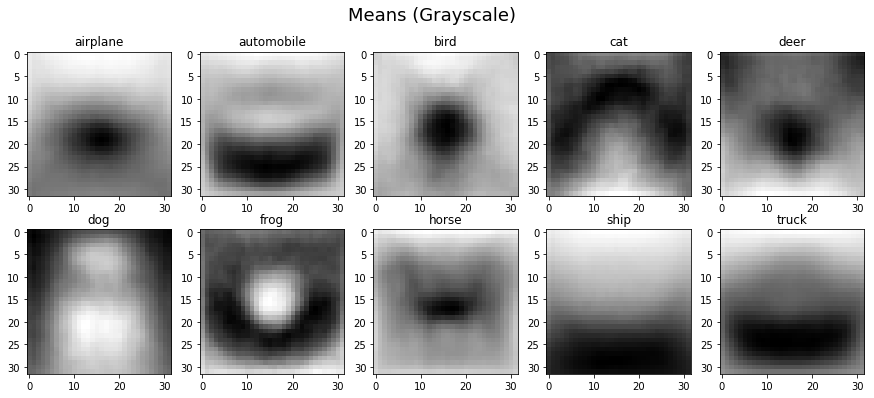

In [10]:
cifarDF = pd.DataFrame(data=X_cifar)
cifarDF["label"] = y_cifar
cifar_means = cifarDF.groupby("label").mean().values.reshape(10,32,32)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Means (Grayscale)', fontsize=18)
for ax, label, image in zip(axes.flat, cifar_label_desc, cifar_means):
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_title(label)
plt.show()

The CIFAR10 dataset will probably be much harder to predict correctly than the Fashion MNIST dataset. The plots above are for many classes quite similar and, most of them dont have very distinguishing feature areas compared to the others.

In [11]:
cifarDF = pd.DataFrame(data=X_cifar_rgb)
cifarDF["label"] = y_cifar
cifar_means = cifarDF.groupby("label").mean().values.reshape(10,32,32,3) / 255

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Means (RGB)', fontsize=18)
for ax, label, image in zip(axes.flat, cifar_label_desc, cifar_means):
    ax.imshow(image, interpolation='none')
    ax.set_title(label)
plt.show()

NameError: name 'X_cifar_rgb' is not defined

# 3. Classification

## 3.a) Implement the Naïve Bayes classifier

The formula for the naive bayes classifier is the following:
<br><br>
$$P(t_{new} = k|X,t,x_{new})=\frac{P(x_{new}|t_{new} = k,X,t)\dot P(t_{new}=k)}{\sum_j P(x_{new}|t_{new}=j,X,t)\dot P(t_{new}=j))}$$
<br><br>
We will be using log-likelihood as our unit of measure, and since 
Naive Bayes makes the assumption that all features are independent, our likelihood folmula will be:
<br><br>
$$p(x_{new}|t_{new}=k,X,t)=\prod_{d=1}^D p(x_d^{new}|t_{new}=k,X,t)$$
<br><br>
We will be using log-likelihood as our unit of measure, and since are predicting over all classes we can remove the marginal likelihood from our formula. So our final formula will be
<br><br>
$$Posterior = ln(likelihood) + ln(prior)$$
<br><br>
where the ln(likelihood) formula is 
<br><br>
$$ ln(likelihood)=-\frac{d}{2}ln(2\pi)-\frac{d}{2}ln(variance)-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)$$
<br><br>
and the prior is
<br><br>
$$prior = \frac{1}{num_{classes}}$$

In [12]:
class NaiveBayesClassifier(object):
    def calcLogLikelihood(self,X,mean,var):
        return mvn.logpdf(X, mean=mean, cov=var)
        
    def fit(self,X,Y):
        X = pd.DataFrame(data=copy.deepcopy(X))
        X["label"] = Y
        self.labels = sorted(X["label"].unique())
        self.mean = X.groupby("label").mean()
        self.var = X.groupby("label").var()
    
    def likelihood(self,x,t):
        mean = self.mean.loc[t].values
        var = self.var.loc[t].values + 1e-2
        log_likelihood = self.calcLogLikelihood(x,mean,var)
        return log_likelihood
    
    def prior(self):
        return 1 / len(self.labels)
    
    def posterior(self,x,t):
        return self.likelihood(x,t) + np.log( self.prior())
    
    def predict(self,X):
        p = np.array([self.posterior(X,t) for t in self.labels]).T
        return p.argmax(axis=1)
    
    def score(self,X,y):
        preds = self.predict(X)
        return np.mean(preds == y)     

## 3.b)  Describe a positive and a negative feature of the classifier for these tasks

### Positive:
The Naive Bayes method is a very simple method to implement. It assumes independence of features, so all that needs to be calculated is the mean an variance of each class. This means that we can process high dimentional feature vectors without problems. One other positive feature of the Naive Bayes classifier is that the model don't have any hyperparameters that needs tuning.
### Negative:
The positive features of the Naive Bayes classifier are also negative ones. Since it assumes feature independence, we are basically saying that pixels are not related to each other, wich in many cases are not correct.

## 3.c) Describe any data pre-processing that you suggest for this data and your classifier

For the fashion MNIST dataset we are normalizing the values to a value in the range [0,1]. 
For the CIFAR10 we are tranforming the RGB values into grayscale values in the range [0,1].

## 3.d) Apply your classifier to the two given datasets. Make sure your optimization is clearly commented. Use classification accuracy and test log-likelihood as your figures of merit

### Optimization

### Fashion MNIST

In [16]:
classifierMnist = NaiveBayesClassifier()
classifierMnist.fit(X_fashion,y_fashion)
print(classifierMnist.score(X_fashion_test,y_fashion_test))

0.679


### CIFAR10

In [17]:
classifierCifar = NaiveBayesClassifier()
classifierCifar.fit(X_cifar,y_cifar)
print(classifierCifar.score(X_cifar_test,y_cifar_test))

0.2554


In [ ]:
#classifier = NaiveBayesClassifier()
#classifier.fit(X_cifar_rgb,y_cifar)
#print(classifier.score(X_cifar_test_rgb,y_cifar_test))

## 3.e)  Display the confusion matrix on the test data

### Fashion MNIST

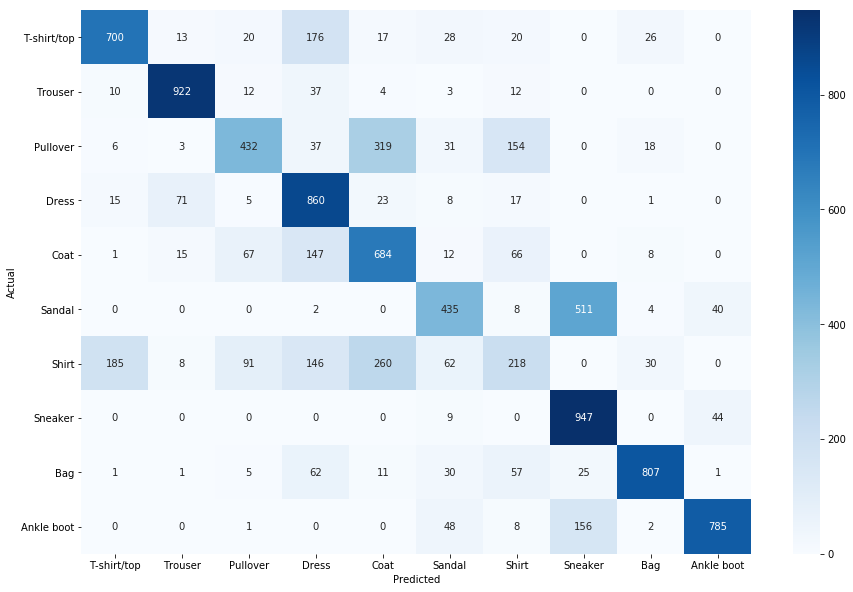

In [18]:
cf = np.zeros((10,10))
for pred,t in zip(classifierMnist.predict(X_fashion_test),y_fashion_test):
    cf[t][pred] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=fashion_label_desc)
df.index = fashion_label_desc

sns.heatmap(df,annot=True, fmt="d",cmap="Blues")
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

As we saw earlier Pullover, Coat and Shirt are hard to distinguish for our Naive Bayes model. Other classes that seems to be miss classified are sandals as sneakers. If we look back at the mean plots from earlier, we can see that also those where quite similar.

### CIFAR10

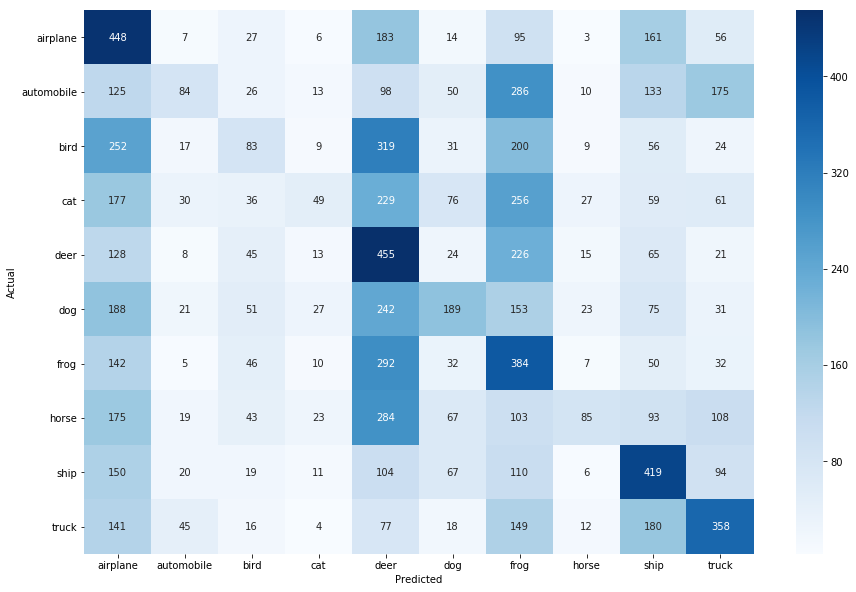

In [19]:
cf = np.zeros((10,10))
for pred,t in zip(classifierCifar.predict(X_cifar_test),y_cifar_test):
    cf[t][pred] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=cifar_label_desc)
df.index = cifar_label_desc

sns.heatmap(df,annot=True, fmt="d",cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

Here we see that not many of our classes are well predicted. Airplane, deer and dog have a high number of correct predictions. But these classes also have a high number of false predictions, so the total accuracy is not that high.

## 3.f) Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved

In [20]:
class RandomClassifier(object):
    def predict(self,X):
        return np.random.random_integers(low=0,high=9,size=len(X))
    
    def score(self,X,y):
        preds = self.predict(X)
        return np.mean(preds == y)

In [21]:
classifier = RandomClassifier()
print("Accuracy on CIFAR10:",classifier.score(X_cifar_test,y_cifar_test))
print("Accuracy on Fashion MNIST:",classifier.score(X_fashion_test,y_fashion_test))

Accuracy on CIFAR10: 0.1028
Accuracy on Fashion MNIST: 0.1019


As expected the random classifier achieves a accuracy of $\frac{1}{num_{classes}}$ which in this case is 0.1. The Naive Bayes model achieves a better accuracy than the random classifier on both datasets, but not by much on the CIFAR10 dataset.

### Improvements

In this case our features are not independent, so the asumption the Naive Bayes model makes are wrong. We could do a principal component analysis to find uncorrelated features, and se if that could help our model.

# 4. Linear Regression

## 4.a) Implement Bayesian linear regression

In [22]:
class LinearRegressor(object):
    def findLabel(self,x):
        if (x < 0):
            return 0
        elif(x > 9):
            return 9
        return np.rint(x)
    
    def var(self,X,y):
        return 1/(X.shape[0]-X.shape[1])
        
    def predStd(self,X):
        None
    def prior(self,X):
        return np.identity(X.shape[1])
    
    def fit(self,X,y):
        X = copy.deepcopy(X)
        X = np.insert(X,0,1,axis=1)
        self.var = np.var(X,axis=0)
        self.sigma2 = np.var(X)
        pr = self.var * self.prior(X)
        inv = np.linalg.inv(X.T.dot(X) + pr)
        self.mean = inv.dot(X.T).dot(y)
        self.cov = self.var * inv
        
    def predict(self,X):
        X = np.insert(X,0,1,axis=1)
        preds = X.dot(self.mean.reshape(-1,1))
        pred_std = self.sigma2 * X.dot(self.cov).dot(X.T).diagonal()
        return preds,pred_std
    
        
    def score(self,X,y):
        preds,_ = self.predict(X)
        preds = np.array(list(map(self.findLabel, preds.ravel())))
        return np.mean(preds == y)

## 4.b)  Treat class labels as continuous and apply regression to the training data

### Fashion MNIST

In [23]:
linearRegressorMnist = LinearRegressor()
linearRegressorMnist.fit(X_fashion,y_fashion)
predMnist,std = linearRegressorMnist.predict(X_fashion_test)

### CIFAR10 

In [24]:
linearRegressorCifar = LinearRegressor()
linearRegressorCifar.fit(X_cifar,y_cifar)
predCifar,std = linearRegressorCifar.predict(X_cifar_test)

## 4.c)  Produce a scatter plot showing the predictions versus the true targets for the test set and compute the mean squared error on the test set

### Fashion MNIST

Mean square error = 14.57


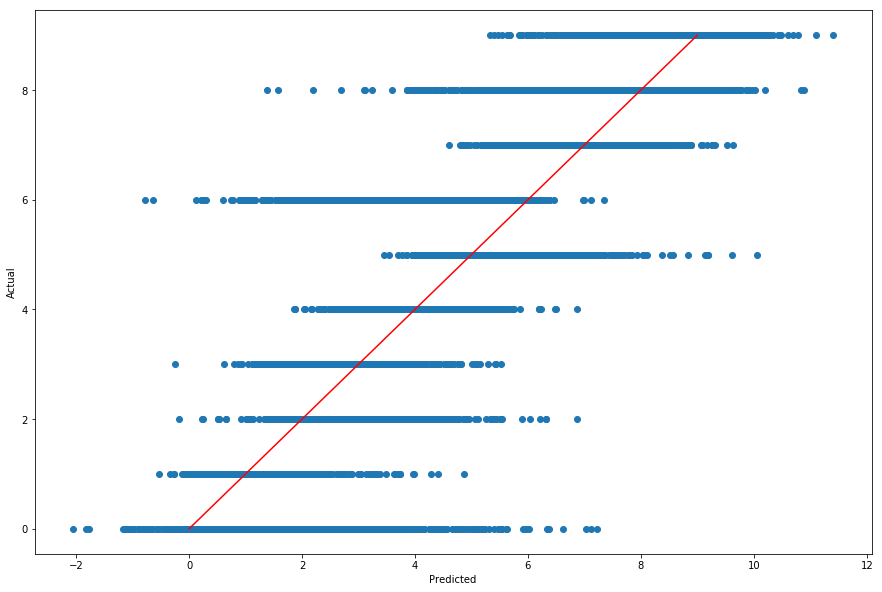

In [26]:
plt.figure(figsize=(15,10))
plt.scatter(predMnist,y_fashion_test)
plt.plot([0,9],[0,9],"r")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show
mse = mean_squared_error(predMnist,y_cifar_test)
print("Mean square error =","{0:.2f}".format(mse))

### CIFAR10 

Mean square error = 8.06


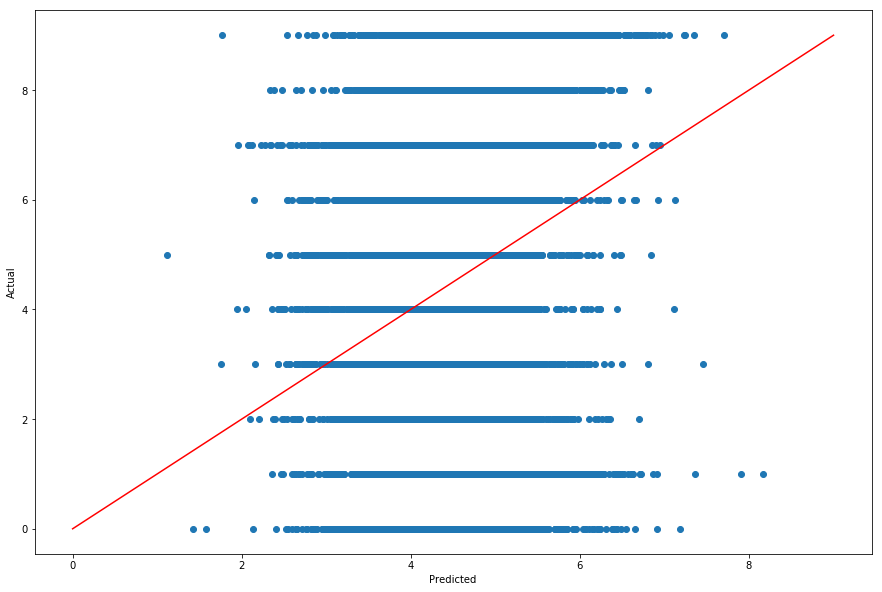

In [27]:
plt.figure(figsize=(15,10))
plt.scatter(predCifar,y_cifar_test)
plt.plot([0,9],[0,9],"r")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show
mse = mean_squared_error(predCifar,y_cifar_test)
#mse = np.mean(np.power(pred - y_cifar_test,2))
print("Mean square error =","{0:.2f}".format(mse))

## 4.d) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy

### Fashion MNIST

In [28]:
linearRegressorMnist = LinearRegressor()
linearRegressorMnist.fit(X_fashion,y_fashion)
accuracy = linearRegressorMnist.score(X_fashion_test,y_fashion_test)
print("Accuracy =","{0:.4f}".format(accuracy))

Accuracy = 0.3919


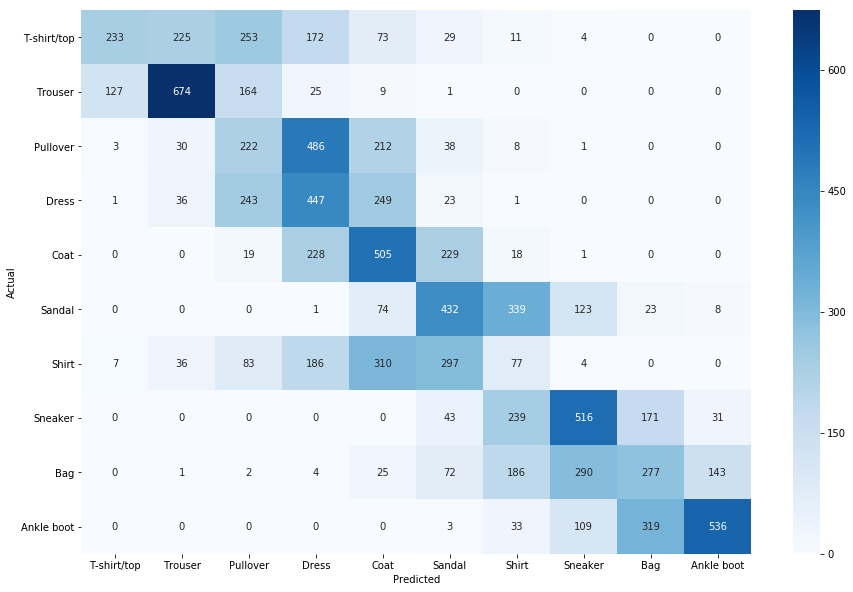

In [29]:
preds,std = linearRegressorMnist.predict(X_fashion_test)
preds_labeled = list(map(linearRegressorMnist.findLabel, preds.ravel()))

cf = np.zeros((10,10))
for pred,t in zip(preds_labeled,y_fashion_test):
    cf[t][int(pred)] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=fashion_label_desc)
df.index = fashion_label_desc

sns.heatmap(df,annot=True, fmt="d",cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

### CIFAR10 

In [30]:
linearRegressorCifar = LinearRegressor()
linearRegressorCifar.fit(X_cifar,y_cifar)
accuracy = linearRegressorCifar.score(X_cifar_test,y_cifar_test)
print("Accuracy =","{0:.4f}".format(accuracy))

Accuracy = 0.1011


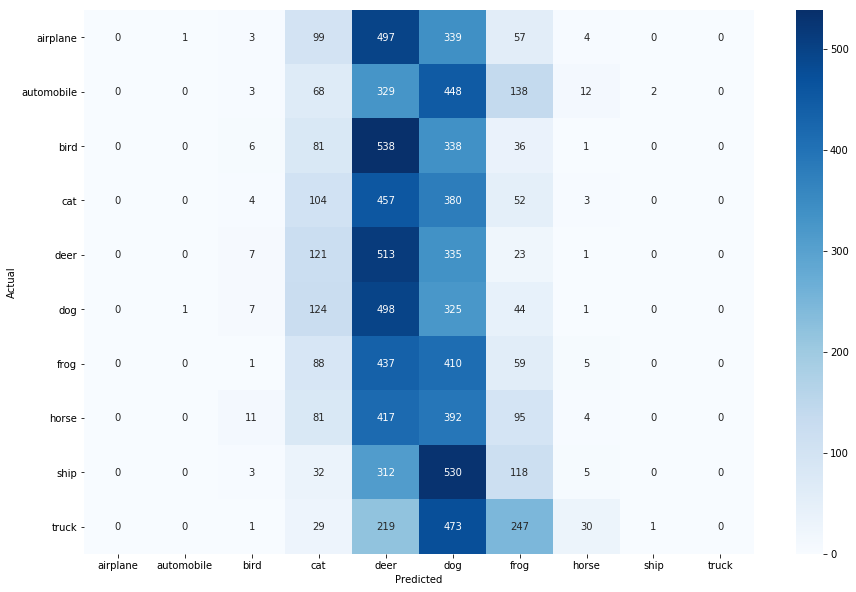

In [31]:
preds,std = linearRegressorCifar.predict(X_cifar_test)
preds_labeled = list(map(linearRegressorCifar.findLabel, preds.ravel()))

cf = np.zeros((10,10))
for pred,t in zip(preds_labeled,y_cifar_test):
    cf[t][int(pred)] += 1
plt.figure(figsize=(15,10))

df = pd.DataFrame(data=cf.astype(int),columns=cifar_label_desc)
df.index = cifar_label_desc

sns.heatmap(df,annot=True, fmt="d",cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0) 
plt.show()

## 4.e) Discuss regression performance with respect to classification performance

## 4.f) Describe one limitation of using regression for this particular task

# Bonus. CNN

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0., shape=shape)
    return tf.Variable(initial)

def LeNet5_Model(image):
    
    # Layer 1.
    conv1_w = weight_variable([5,5,1,6])
    conv1_b = bias_variable([6])
    conv1 = tf.nn.conv2d(image,conv1_w,strides = [1,1,1,1], padding = "SAME") + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling 1.
    pool_1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    # Layer 2.
    conv2_w = weight_variable([5,5,6,16])
    conv2_b = bias_variable([16])
    conv2 = tf.nn.conv2d(pool_1,conv2_w,strides = [1,1,1,1],padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Pooling 2.
    pool_2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding = 'VALID')
    
    # Flatten.
    fc1 = flatten(pool_2)
    
    # Layer 3.
    fc1_w = weight_variable([400,120])
    fc1_b = bias_variable([120])
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # Layer 4.
    fc2_w = weight_variable([120,84])
    fc2_b = bias_variable([84])
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    
    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5
    fc3_w = weight_variable([84,10])
    fc3_b = bias_variable([10])
    
    logits = tf.nn.softmax(tf.matmul(fc2,fc3_w) + fc3_b)
    return logits

def evaluate(logits, labels):
    # logits will be the outputs of your model, labels will be one-hot vectors corresponding to the actual labels
    # logits and labels are numpy arrays
    # this function should return the accuracy of your model
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [ ]:
def train(init, sess, n_epochs, batch_size, optimizer, cost):
    # optimizer and cost are the same kinds of objects as in Section 1
    sess.run(init)
    #print(X_fashion.shape)
    #print(y_fashion.reshape(-1,1).shape)
    
    #data = np.dstack((X_fashion,y_fashion.reshape(-1,1)))
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(X_fashion)/batch_size)
        p = np.random.permutation(len(X_fashion))
        X_train = X_fashion[p]
        y_train = y_fashion[p]
        # Loop over all batches
        for i in range(total_batch):
            offset = i * batch_size
            
            if(offset+batch_size > len(X_train)):
                batch_xs, batch_ys = X_train[offset:],y_train[offset:]
            else:
                batch_xs, batch_ys = X_train[offset:offset+batch_size],y_train[offset:offset+batch_size]
            
            ys = np.zeros((len(batch_ys),10))
            for j in range(len(batch_ys)):
                label = batch_ys[j]
                ys[j][label] = 1
            
            #print(epoch,i,offset,batch_xs.shape)
            batch_xs = batch_xs.reshape(-1,28,28,1).astype(np.float32)
            ys = ys.astype(np.float32)
            
            _, c = sess.run([optimizer, cost],
                                     feed_dict={x: batch_xs, y: ys})

            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: ", '%02d' % (epoch+1), "  =====> Loss=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")
    
    X_test = X_fashion_test.reshape(-1,28,28,1).astype(np.float32)
    y_test = np.zeros((len(y_fashion_test),10))
    for j in range(len(y_fashion_test)):
        label = y_fashion_test[j]
        y_test[j][label] = 1
    # Test model
    # Calculate accuracy
    print("Accuracy:", acc.eval({x: X_test, y: y_test}))

In [ ]:
tf.reset_default_graph() # reset the default graph before defining a new model

# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 128
epsilon = 1e-10
display_step = 1

x = tf.placeholder(tf.float32, [None, 28,28,1], name='InputData')
y = tf.placeholder(tf.float32, [None, 10], name='LabelData')

with tf.name_scope('Model'):
    pred = LeNet5_Model(x)
with tf.name_scope('Loss'):
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)), reduction_indices=1))
with tf.name_scope('Adam'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
with tf.name_scope('Accuracy'):
    acc = evaluate(pred, y)
    
    
# Initializing the variables
init = tf.global_variables_initializer()

t0 = time.time()
with tf.Session() as sess:
    train(init, sess, training_epochs, batch_size, optimizer, cost)
    
t1 = time.time()
print("Running time:",t1-t0)